In [1]:
from model import UNET
from util import *
import tensorflow as tf
import numpy as np


import os
import tarfile

In [2]:
dataPath = os.path.join(".","Data","Images")
maskPath = os.path.join(".","Data","Segmentation")
dataType = "*.png"

SEED = 42
DATA_SPLIT = 1

OPTIMIZER = "adam"
LOSS = "binary_crossentropy"
METRICS = ["accuracy"]
BATCH_SIZE = 16
IMAGE_SHAPE = (512,512,1)
KFOLD  = 3 #MUST BE >=2
EPOCHS = 150

In [3]:
if not os.path.isdir(dataPath) or not os.path.isdir(maskPath):
    #untar the data if it hasnt been
    print("UNZIPPING DATA")
    with tarfile.open(os.path.join(".","Data","data.tar.gz")) as file:
        file.extractall(os.path.join(".","Data"))


Metal device set to: Apple M1 Pro
# Folds = 3


2022-03-09 17:47:08.805989: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-09 17:47:08.806123: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-03-09 17:47:08.981356: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-09 17:47:08.981611: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


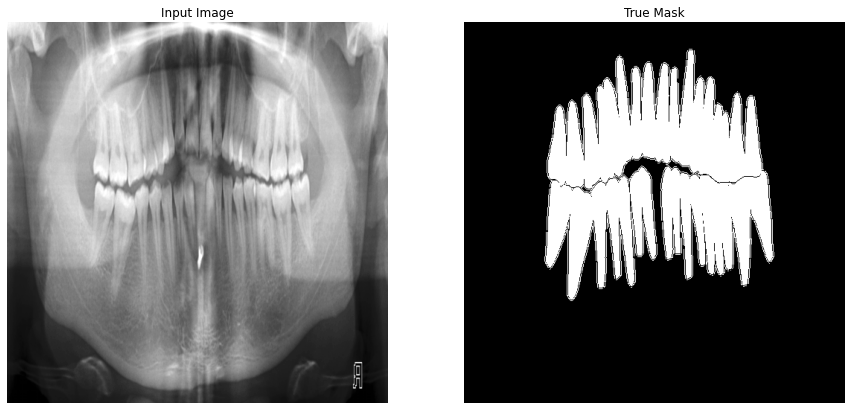

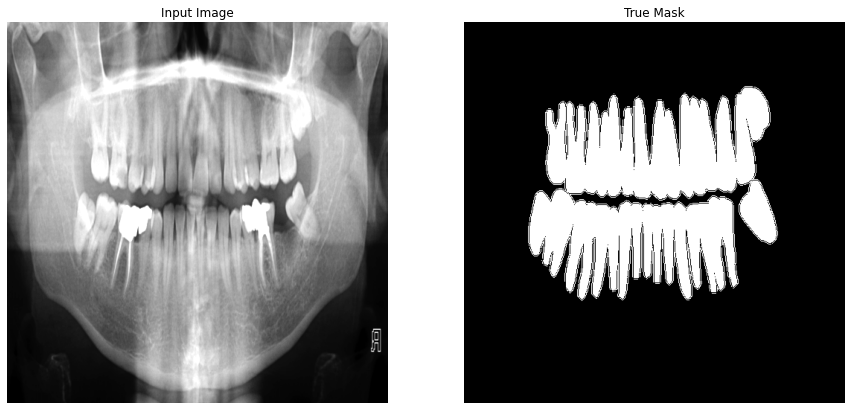

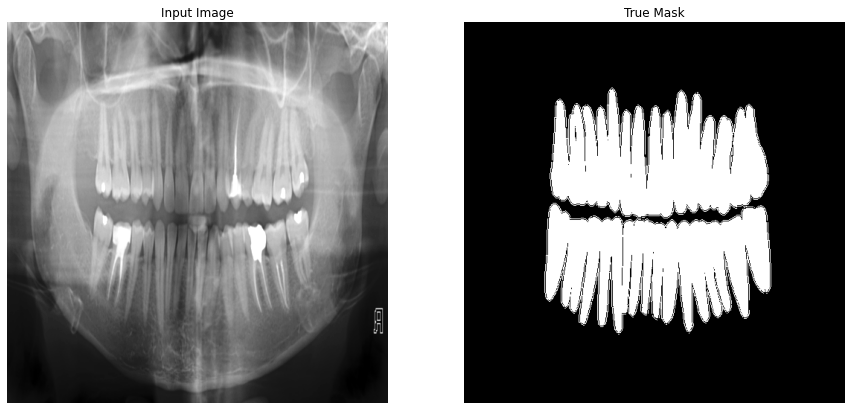

In [4]:
# LOAD DATASET AS TF DATASET
dataset = generate_dataset(dataPath, dataType, seed=SEED, img_shape = IMAGE_SHAPE, batch_size = BATCH_SIZE,
                          kfold = KFOLD, repeat_count = 1)
print("# Folds = {}".format(len(dataset)))
for element in dataset[0].take(1): #take a batch
    for b in range(min(3,BATCH_SIZE)): #now have a tuple
        display_mask_image([element[0][b],element[1][b]])


In [5]:
histories = []
for k in range(KFOLD):
    print("Doing k-fold {} of {}".format(k+1,KFOLD))
    test_dataset = dataset[k]
    train_datasets = []
    for k2 in range(KFOLD):
        if k2 == k:
            continue
        train_datasets.append(dataset[k2])
    train_dataset = train_datasets[0]
    for ds in train_datasets[1:]:
        train_dataset = train_dataset.concatenate(ds)
    
    model = UNET(input_shape = IMAGE_SHAPE)
    model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)
    history = model.fit(train_dataset, validation_data = test_dataset, \
                            epochs = EPOCHS, verbose = 1)
    histories.append(history.history)

history  = {}
history["loss"] = np.mean([hstry["loss"] for hstry in histories],axis=0)
history["accuracy"] = np.mean([hstry["accuracy"] for hstry in histories],axis=0)
history["val_loss"] = np.mean([hstry["val_loss"] for hstry in histories],axis=0)
history["val_accuracy"] = np.mean([hstry["val_accuracy"] for hstry in histories],axis=0)

Doing k-fold 1 of 3
Epoch 1/120


2022-03-09 17:47:10.346337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.6212 - accuracy: 0.6505

2022-03-09 17:47:30.200200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 24s 4s/step - loss: 0.6212 - accuracy: 0.6505 - val_loss: 3.0743 - val_accuracy: 0.7473
Epoch 2/120
6/6 [==============================] - 23s 4s/step - loss: 0.4619 - accuracy: 0.7770 - val_loss: 3.9713 - val_accuracy: 0.5045
Epoch 3/120
6/6 [==============================] - 23s 4s/step - loss: 0.3789 - accuracy: 0.7989 - val_loss: 20.8145 - val_accuracy: 0.7487
Epoch 4/120
6/6 [==============================] - 23s 4s/step - loss: 0.3039 - accuracy: 0.8574 - val_loss: 22.1788 - val_accuracy: 0.6576
Epoch 5/120
6/6 [==============================] - 23s 4s/step - loss: 0.2705 - accuracy: 0.8818 - val_loss: 9.7173 - val_accuracy: 0.7707
Epoch 6/120
6/6 [==============================] - 23s 4s/step - loss: 0.2247 - accuracy: 0.9073 - val_loss: 9.8865 - val_accuracy: 0.8018
Epoch 7/120
6/6 [==============================] - 23s 4s/step - loss: 0.2085 - accuracy: 0.9161 - val_loss: 4.9776 - val_accuracy: 0.7651
Epoch 8/120
6/6 [====================

6/6 [==============================] - 23s 4s/step - loss: 0.0874 - accuracy: 0.9626 - val_loss: 0.1400 - val_accuracy: 0.9455
Epoch 60/120
6/6 [==============================] - 23s 4s/step - loss: 0.0828 - accuracy: 0.9634 - val_loss: 0.1112 - val_accuracy: 0.9545
Epoch 61/120
6/6 [==============================] - 23s 4s/step - loss: 0.0836 - accuracy: 0.9631 - val_loss: 0.0958 - val_accuracy: 0.9599
Epoch 62/120
6/6 [==============================] - 23s 4s/step - loss: 0.0930 - accuracy: 0.9596 - val_loss: 0.1209 - val_accuracy: 0.9498
Epoch 63/120
6/6 [==============================] - 23s 4s/step - loss: 0.0935 - accuracy: 0.9605 - val_loss: 0.1566 - val_accuracy: 0.9457
Epoch 64/120
6/6 [==============================] - 23s 4s/step - loss: 0.0910 - accuracy: 0.9614 - val_loss: 0.1238 - val_accuracy: 0.9492
Epoch 65/120
6/6 [==============================] - 23s 4s/step - loss: 0.0863 - accuracy: 0.9626 - val_loss: 0.1233 - val_accuracy: 0.9513
Epoch 66/120
6/6 [===============

6/6 [==============================] - 23s 4s/step - loss: 0.0702 - accuracy: 0.9678 - val_loss: 0.0896 - val_accuracy: 0.9605
Epoch 118/120
6/6 [==============================] - 23s 4s/step - loss: 0.0688 - accuracy: 0.9682 - val_loss: 0.0779 - val_accuracy: 0.9661
Epoch 119/120
6/6 [==============================] - 23s 4s/step - loss: 0.0698 - accuracy: 0.9676 - val_loss: 0.1081 - val_accuracy: 0.9578
Epoch 120/120
6/6 [==============================] - 23s 4s/step - loss: 0.0681 - accuracy: 0.9689 - val_loss: 0.0907 - val_accuracy: 0.9606
Doing k-fold 2 of 3
Epoch 1/120


2022-03-09 18:33:16.398411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.7135 - accuracy: 0.5781

2022-03-09 18:33:35.994167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 24s 4s/step - loss: 0.7135 - accuracy: 0.5781 - val_loss: 126.0207 - val_accuracy: 0.7525
Epoch 2/120
6/6 [==============================] - 23s 4s/step - loss: 0.5178 - accuracy: 0.7533 - val_loss: 350.2227 - val_accuracy: 0.7539
Epoch 3/120
6/6 [==============================] - 23s 4s/step - loss: 0.4770 - accuracy: 0.7498 - val_loss: 138.7207 - val_accuracy: 0.7511
Epoch 4/120
6/6 [==============================] - 23s 4s/step - loss: 0.3735 - accuracy: 0.7921 - val_loss: 112.2607 - val_accuracy: 0.7710
Epoch 5/120
6/6 [==============================] - 23s 4s/step - loss: 0.2877 - accuracy: 0.8722 - val_loss: 28.5434 - val_accuracy: 0.7202
Epoch 6/120
6/6 [==============================] - 23s 4s/step - loss: 0.2269 - accuracy: 0.9043 - val_loss: 10.3151 - val_accuracy: 0.7425
Epoch 7/120
6/6 [==============================] - 23s 4s/step - loss: 0.2234 - accuracy: 0.9086 - val_loss: 21.5449 - val_accuracy: 0.7478
Epoch 8/120
6/6 [===========

6/6 [==============================] - 23s 4s/step - loss: 0.0931 - accuracy: 0.9597 - val_loss: 0.1715 - val_accuracy: 0.9350
Epoch 60/120
6/6 [==============================] - 23s 4s/step - loss: 0.0869 - accuracy: 0.9624 - val_loss: 0.1222 - val_accuracy: 0.9521
Epoch 61/120
6/6 [==============================] - 23s 4s/step - loss: 0.0854 - accuracy: 0.9626 - val_loss: 0.1417 - val_accuracy: 0.9486
Epoch 62/120
6/6 [==============================] - 23s 4s/step - loss: 0.0792 - accuracy: 0.9646 - val_loss: 0.1121 - val_accuracy: 0.9562
Epoch 63/120
6/6 [==============================] - 23s 4s/step - loss: 0.0847 - accuracy: 0.9635 - val_loss: 0.1216 - val_accuracy: 0.9526
Epoch 64/120
6/6 [==============================] - 23s 4s/step - loss: 0.0931 - accuracy: 0.9620 - val_loss: 0.1151 - val_accuracy: 0.9533
Epoch 65/120
6/6 [==============================] - 23s 4s/step - loss: 0.0891 - accuracy: 0.9616 - val_loss: 0.1469 - val_accuracy: 0.9437
Epoch 66/120
6/6 [===============

6/6 [==============================] - 23s 4s/step - loss: 0.0668 - accuracy: 0.9690 - val_loss: 0.0920 - val_accuracy: 0.9618
Epoch 118/120
6/6 [==============================] - 23s 4s/step - loss: 0.0662 - accuracy: 0.9691 - val_loss: 0.0761 - val_accuracy: 0.9677
Epoch 119/120
6/6 [==============================] - 23s 4s/step - loss: 0.0653 - accuracy: 0.9693 - val_loss: 0.0865 - val_accuracy: 0.9641
Epoch 120/120
6/6 [==============================] - 23s 4s/step - loss: 0.0646 - accuracy: 0.9694 - val_loss: 0.0724 - val_accuracy: 0.9683
Doing k-fold 3 of 3
Epoch 1/120


2022-03-09 19:19:06.024937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.5625 - accuracy: 0.7145

2022-03-09 19:19:25.660961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 23s 4s/step - loss: 0.5625 - accuracy: 0.7145 - val_loss: 21.7281 - val_accuracy: 0.7636
Epoch 2/120
6/6 [==============================] - 23s 4s/step - loss: 0.4698 - accuracy: 0.7616 - val_loss: 2.1145 - val_accuracy: 0.7209
Epoch 3/120
6/6 [==============================] - 23s 4s/step - loss: 0.3442 - accuracy: 0.8197 - val_loss: 27.6788 - val_accuracy: 0.7364
Epoch 4/120
6/6 [==============================] - 23s 4s/step - loss: 0.2908 - accuracy: 0.8619 - val_loss: 21.0959 - val_accuracy: 0.6066
Epoch 5/120
6/6 [==============================] - 23s 4s/step - loss: 0.2299 - accuracy: 0.9019 - val_loss: 32.5040 - val_accuracy: 0.3681
Epoch 6/120
6/6 [==============================] - 23s 4s/step - loss: 0.2177 - accuracy: 0.9067 - val_loss: 5.8953 - val_accuracy: 0.6969
Epoch 7/120
6/6 [==============================] - 23s 4s/step - loss: 0.2155 - accuracy: 0.9060 - val_loss: 3.1047 - val_accuracy: 0.7250
Epoch 8/120
6/6 [==================

6/6 [==============================] - 24s 4s/step - loss: 0.0872 - accuracy: 0.9616 - val_loss: 0.1202 - val_accuracy: 0.9524
Epoch 60/120
6/6 [==============================] - 24s 4s/step - loss: 0.0975 - accuracy: 0.9587 - val_loss: 0.1368 - val_accuracy: 0.9408
Epoch 61/120
6/6 [==============================] - 25s 4s/step - loss: 0.0964 - accuracy: 0.9590 - val_loss: 0.1276 - val_accuracy: 0.9481
Epoch 62/120
6/6 [==============================] - 24s 4s/step - loss: 0.0988 - accuracy: 0.9594 - val_loss: 0.1723 - val_accuracy: 0.9321
Epoch 63/120
6/6 [==============================] - 24s 4s/step - loss: 0.1050 - accuracy: 0.9573 - val_loss: 0.1797 - val_accuracy: 0.9340
Epoch 64/120
6/6 [==============================] - 24s 4s/step - loss: 0.0973 - accuracy: 0.9582 - val_loss: 0.1266 - val_accuracy: 0.9466
Epoch 65/120
6/6 [==============================] - 24s 4s/step - loss: 0.0876 - accuracy: 0.9616 - val_loss: 0.1273 - val_accuracy: 0.9495
Epoch 66/120
6/6 [===============

6/6 [==============================] - 23s 4s/step - loss: 0.0757 - accuracy: 0.9674 - val_loss: 0.1386 - val_accuracy: 0.9488
Epoch 118/120
6/6 [==============================] - 23s 4s/step - loss: 0.0715 - accuracy: 0.9677 - val_loss: 0.0972 - val_accuracy: 0.9618
Epoch 119/120
6/6 [==============================] - 23s 4s/step - loss: 0.0779 - accuracy: 0.9657 - val_loss: 0.0964 - val_accuracy: 0.9599
Epoch 120/120
6/6 [==============================] - 23s 4s/step - loss: 0.0705 - accuracy: 0.9678 - val_loss: 0.1118 - val_accuracy: 0.9568


# Lets view results after training

2022-03-09 20:15:51.995420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


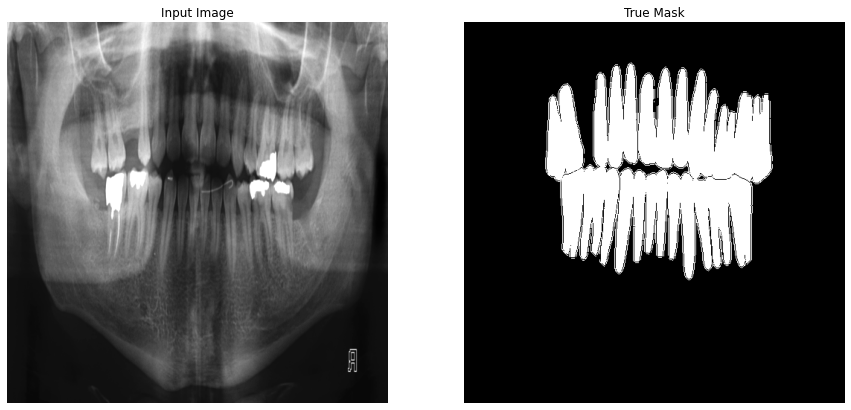

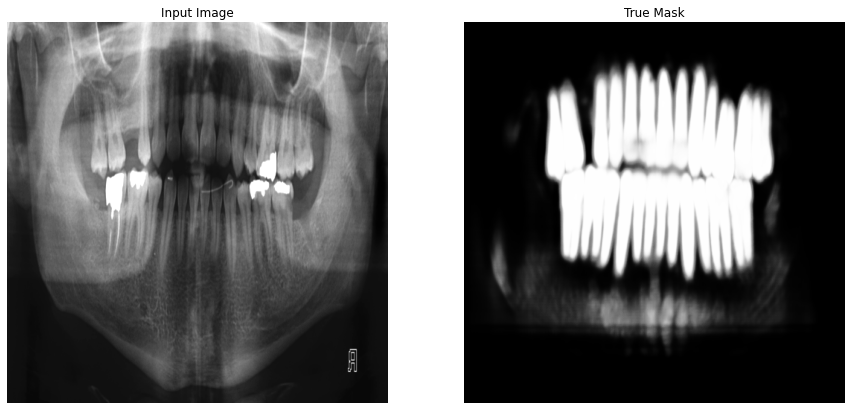

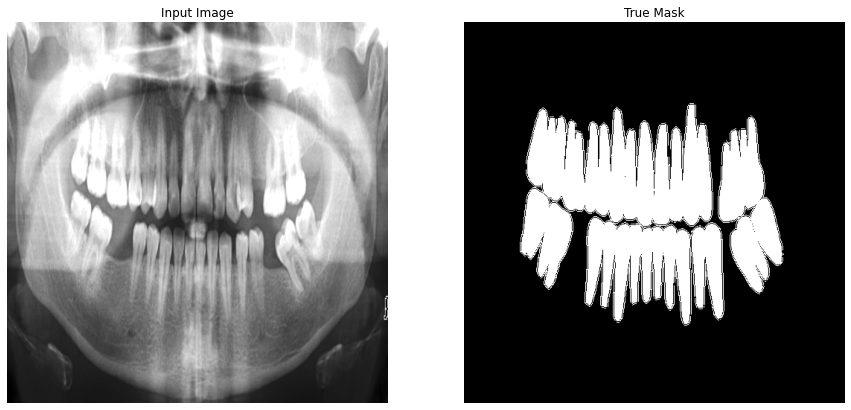

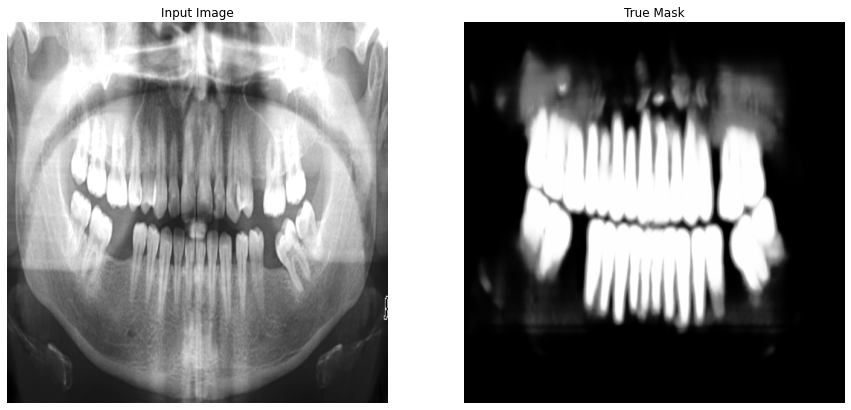

In [14]:
#TRAINING
for element in dataset[0].take(1): #take a batch
    predictions = model.predict(element[0])
    for b in range(min(2,BATCH_SIZE)): #now have a tuple
        display_mask_image([element[0][b],element[1][b]])
        display_mask_image([element[0][b],predictions[b]])

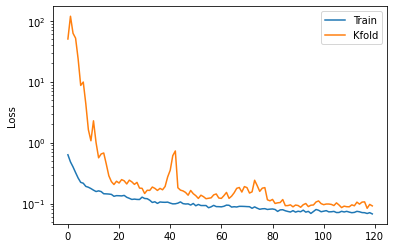

In [12]:
plt.semilogy(history["loss"],label="Train")
plt.semilogy(history["val_loss"],label="Kfold")
plt.ylabel("Loss")
plt.legend()

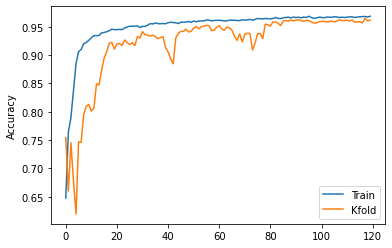

In [13]:
plt.plot(history["accuracy"],label="Train")
plt.plot(history["val_accuracy"],label="Kfold")
plt.ylabel("Accuracy")
plt.legend()